In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator, Aer
from qiskit.visualization import plot_state_qsphere

In [2]:
# Helper function
def string_to_bits(s):
    bits = []
    for char in s:
        byte = ord(char)            # Get ASCII code
        bin_str = format(byte, '08b')  # Binary string with leading zeros
        bits.extend(int(b) for b in bin_str)
    return bits

def bits_to_string(bits):
    chars = []
    # Process bits in chunks of 8
    for i in range(0, len(bits), 8):
        byte_bits = bits[i:i+8]               # Get 8 bits
        byte_str = ''.join(str(b) for b in byte_bits)  # Convert bits to string
        byte_int = int(byte_str, 2)          # Convert binary string to int
        chars.append(chr(byte_int))           # Convert int to char
    return ''.join(chars)

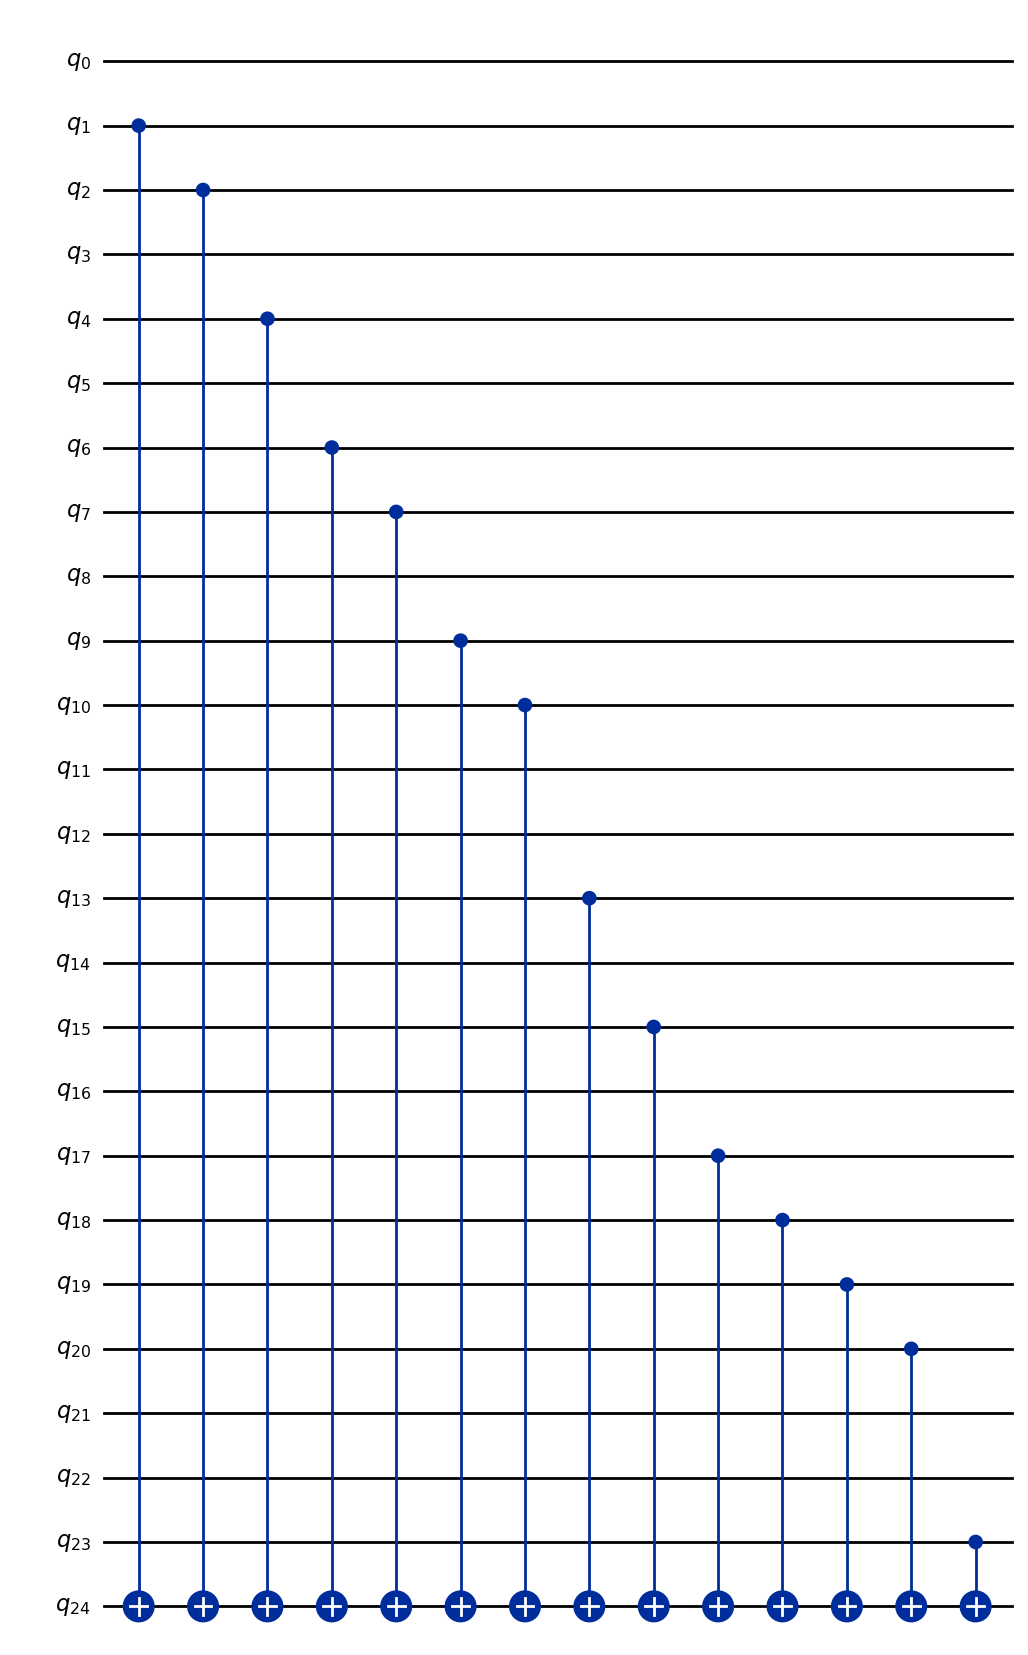

In [3]:
secret_string = "key"

secret_bits = string_to_bits(secret_string)

n = len(secret_bits)

# Let's begin by defining our oracle
def create_oracle(n):
    oracle = QuantumCircuit(n + 1)

    for i in range(n):
        if(secret_bits[i] == 1):
            oracle.cx(i, n)

    return oracle

oracle = create_oracle(n)

oracle.draw('mpl')

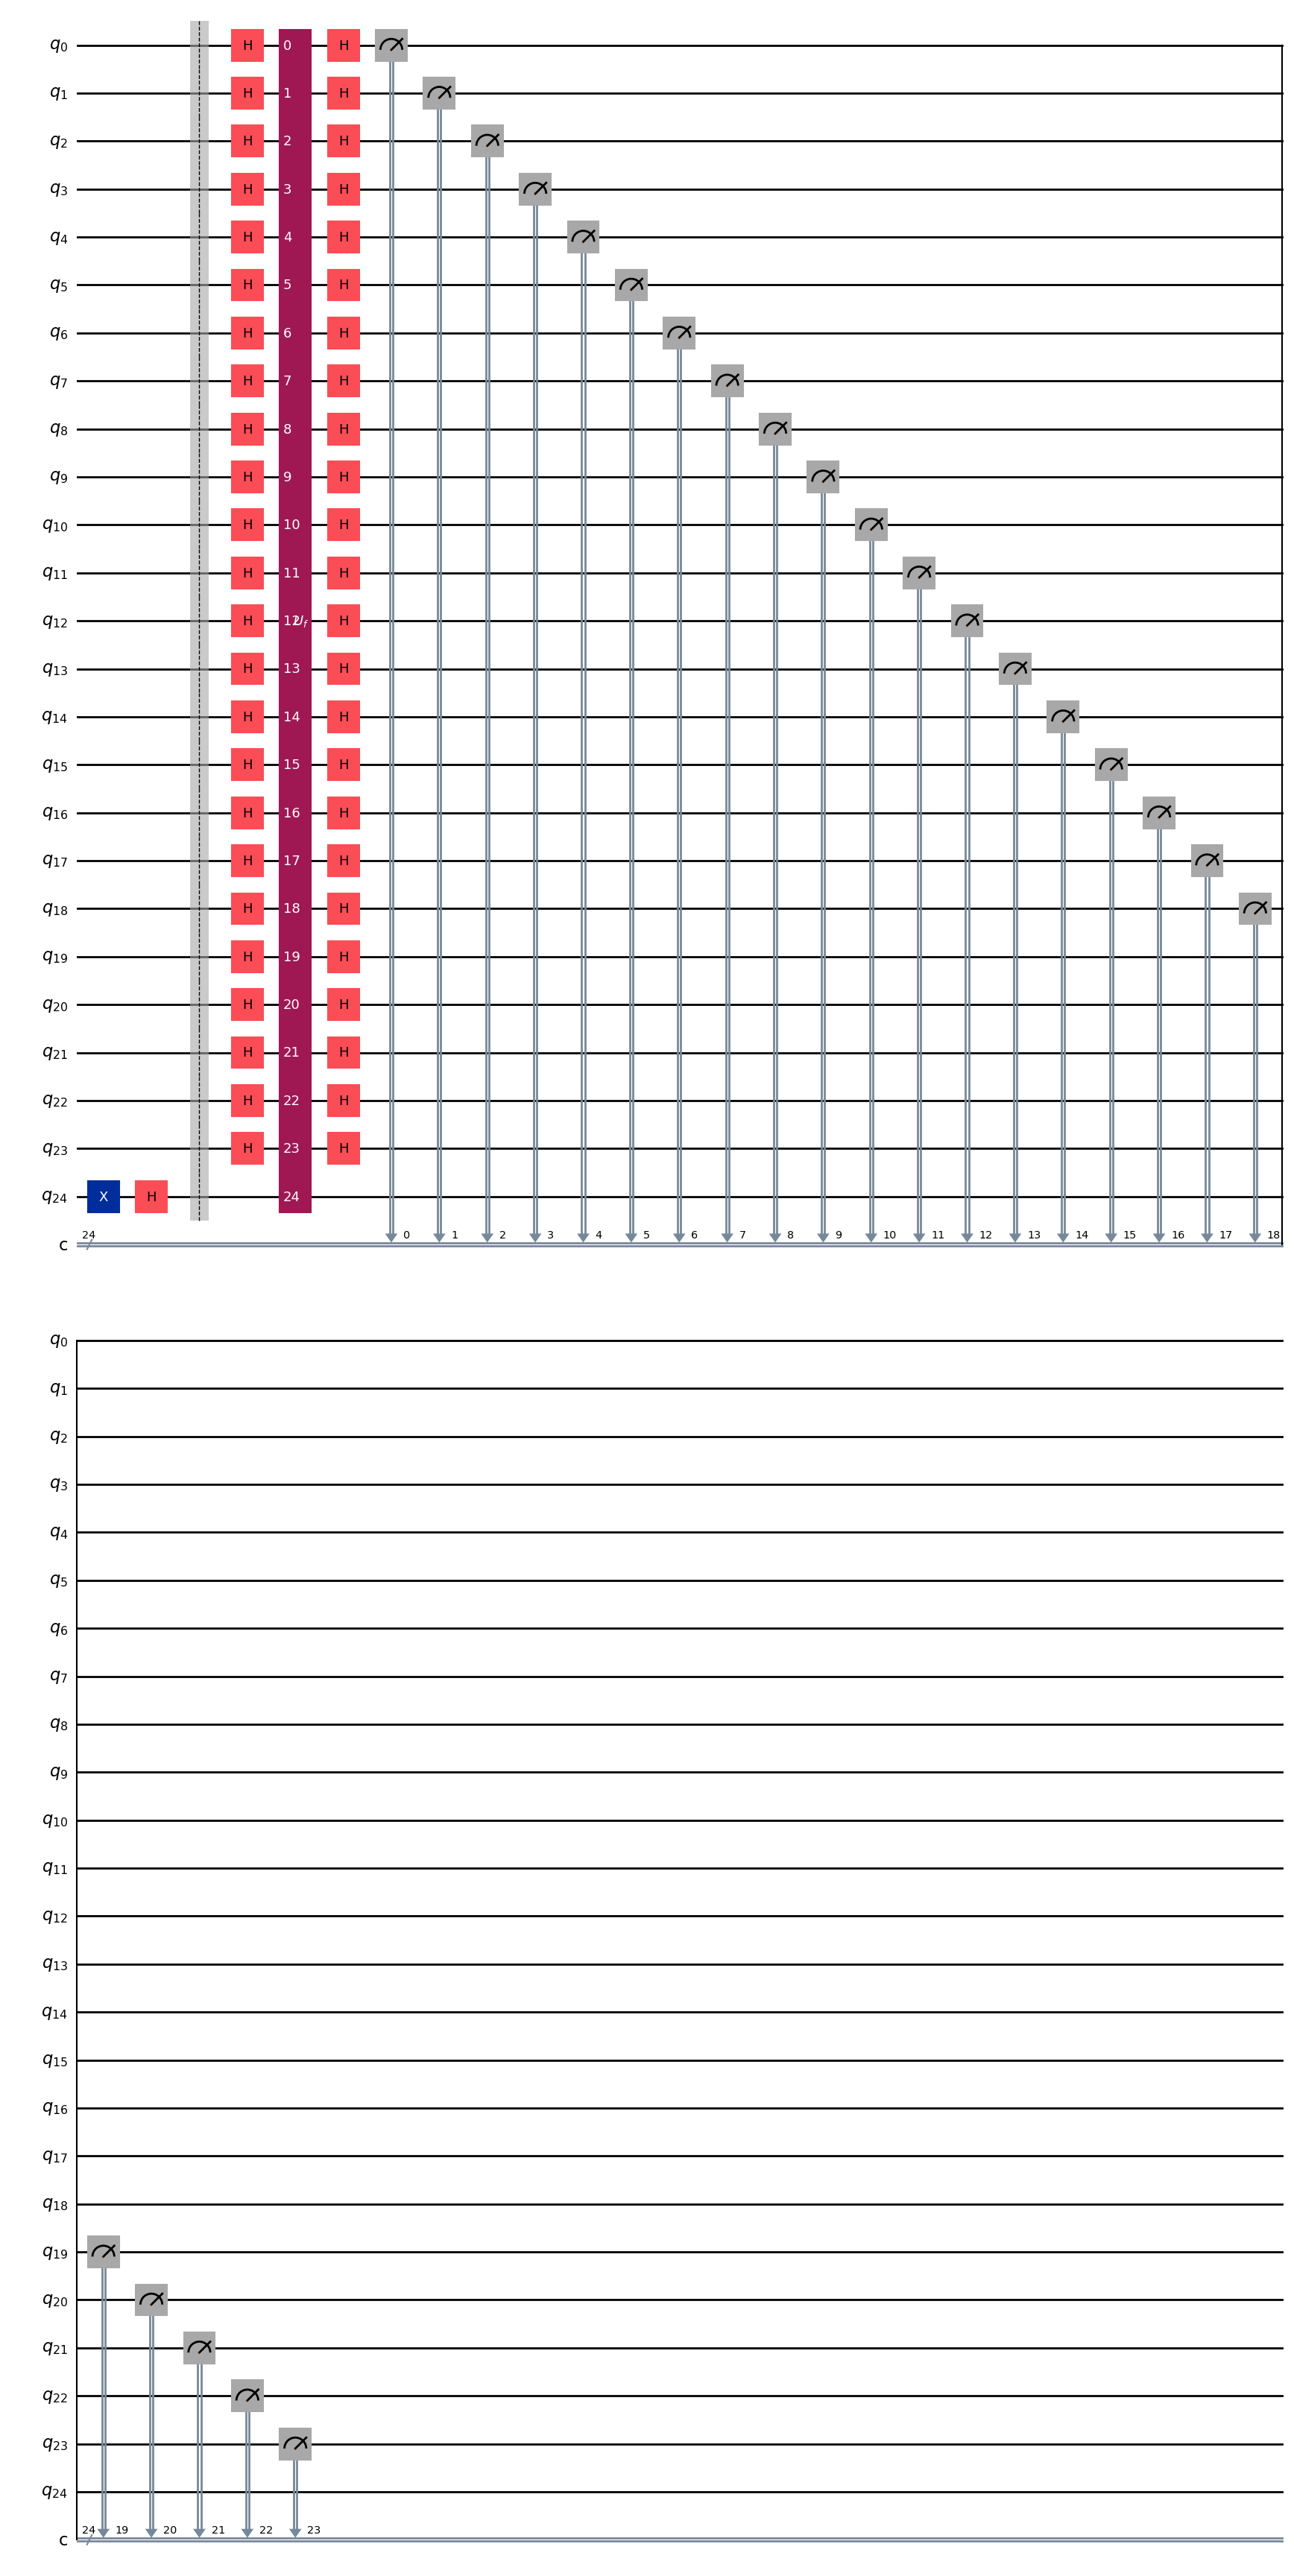

In [4]:
def create_bernstein_vazirani_circuit(n):
    circuit = QuantumCircuit(n + 1, n)

    # prepare ancilla qubit
    circuit.x(n)
    circuit.h(n)

    # Begin the main circuit
    circuit.barrier()

    # Set all qubits in super position
    for i in range(n):
        circuit.h(i)

    Uf = oracle.to_gate()
    Uf.label = "$U_f$"

    # Step 2: apply oracle
    circuit.compose(Uf, inplace=True)

    # Again, apply Hadamard to all $n$ qubits
    for i in range(n):
        circuit.h(i)
        circuit.measure(i, i)

    return circuit

qc = create_bernstein_vazirani_circuit(n)

qc.draw('mpl')


In [5]:
# --- Simulation ---
simulator = AerSimulator()

# Need to use transpile() here to simplify my oracle circuit $U_f$
qct = transpile(qc, simulator)
print(qct)

                    ░      ┌─┐                                             »
 q_0: ──────────────░──────┤M├─────────────────────────────────────────────»
                    ░ ┌───┐└╥┘                                ┌───┐     ┌─┐»
 q_1: ──────────────░─┤ H ├─╫──────────────────────────────■──┤ H ├─────┤M├»
                    ░ ├───┤ ║                              │  └───┘┌───┐└╥┘»
 q_2: ──────────────░─┤ H ├─╫──────────────────────────────┼────■──┤ H ├─╫─»
                    ░ └───┘ ║ ┌─┐                          │    │  └───┘ ║ »
 q_3: ──────────────░───────╫─┤M├──────────────────────────┼────┼────────╫─»
                    ░ ┌───┐ ║ └╥┘                          │    │        ║ »
 q_4: ──────────────░─┤ H ├─╫──╫───────────────────────────┼────┼────■───╫─»
                    ░ └───┘ ║  ║ ┌─┐                       │    │    │   ║ »
 q_5: ──────────────░───────╫──╫─┤M├───────────────────────┼────┼────┼───╫─»
                    ░ ┌───┐ ║  ║ └╥┘                       │    │    │   ║ »

In [6]:
result = Aer.get_backend('statevector_simulator').run(qct, shots=1).result()
counts = result.get_counts(qct)


# --- Plotting ---
# Get the statevector from the result
statevector = result.get_statevector(qct)

# Plot the statevector on a Q-sphere
#plot_state_qsphere(statevector)

In [ ]:
# Get the secret string
counts = result.get_counts(qct)

print("Counts:", counts)

# Get the output and reverse it
key = next(iter(counts))[::-1]

# Convert each character to an integer
bits = [int(b) for b in key]

print("Secret string:", bits_to_string(bits))

Counts: {'100111101010011011010110': 1}
Secret string: key
